# Step1: 加载和预处理数据

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

# 加载数据
user_log = pd.read_csv('user_log_format1.csv')
user_info = pd.read_csv('user_info_format1.csv')
train = pd.read_csv('train_format1.csv')
test = pd.read_csv('test_format1.csv')

In [4]:
# 分离特征和标签
X = train.drop(columns=['user_id', 'merchant_id', 'label'])  # 去除不必要列
y = train['label']

# Step 2: 特征工程

## 1. 提取用户-商家交互特征
这里提取用户点击、加购、购买和收藏操作的次数，并计算每位用户对每个商家的交互频次。

In [5]:
# 提取用户-商家交互特征
user_merchant_interactions = user_log.groupby(['user_id', 'seller_id']).agg(
    clicks=('action_type', lambda x: (x == 0).sum()),
    add_to_cart=('action_type', lambda x: (x == 1).sum()),
    purchases=('action_type', lambda x: (x == 2).sum()),
    favorites=('action_type', lambda x: (x == 3).sum()),
    total_interactions=('action_type', 'count'),
    days_active=('time_stamp', 'nunique')
).reset_index()

## 2. 统计用户购买行为特征
通过聚合计算用户在所有商家上的交互总数，包括不同操作的次数和唯一商家数。

In [6]:
# 统计用户购买行为特征
user_stats = user_log.groupby('user_id').agg(
    total_purchases=('action_type', lambda x: (x == 2).sum()),
    total_clicks=('action_type', lambda x: (x == 0).sum()),
    total_add_to_cart=('action_type', lambda x: (x == 1).sum()),
    total_favorites=('action_type', lambda x: (x == 3).sum()),
    unique_merchants=('seller_id', 'nunique'),
    total_interactions=('action_type', 'count'),
    days_active=('time_stamp', 'nunique')
).reset_index()

## 3. 统计商家特征

In [7]:
# 提取商家特征
merchant_stats = user_log.groupby('seller_id').agg(
    merchant_total_purchases=('action_type', lambda x: (x == 2).sum()),
    merchant_total_clicks=('action_type', lambda x: (x == 0).sum()),
    merchant_total_add_to_cart=('action_type', lambda x: (x == 1).sum()),
    merchant_total_favorites=('action_type', lambda x: (x == 3).sum()),
    merchant_unique_users=('user_id', 'nunique'),
    merchant_total_interactions=('action_type', 'count'),
    merchant_days_active=('time_stamp', 'nunique')
).reset_index()

## 4. 计算用户和商家各自的点击转化率等

In [8]:
# 计算用户的点击转化率、加购转化率等
user_stats['click_purchase_ratio'] = user_stats['total_clicks'] / (user_stats['total_purchases'] + 1)
user_stats['add_to_cart_purchase_ratio'] = user_stats['total_add_to_cart'] / (user_stats['total_purchases'] + 1)
user_stats['click_favorite_ratio'] = user_stats['total_clicks'] / (user_stats['total_favorites'] + 1)
user_stats['interaction_per_merchant'] = user_stats['total_interactions'] / (user_stats['unique_merchants'] + 1)
user_stats['interaction_per_day'] = user_stats['total_interactions'] / (user_stats['days_active'] + 1)

In [9]:
# 计算商家的点击转化率、加购转化率等
merchant_stats['merchant_click_purchase_ratio'] = merchant_stats['merchant_total_clicks'] / (merchant_stats['merchant_total_purchases'] + 1)
merchant_stats['merchant_add_to_cart_purchase_ratio'] = merchant_stats['merchant_total_add_to_cart'] / (merchant_stats['merchant_total_purchases'] + 1)
merchant_stats['merchant_click_favorite_ratio'] = merchant_stats['merchant_total_clicks'] / (merchant_stats['merchant_total_favorites'] + 1)
merchant_stats['merchant_interaction_per_user'] = merchant_stats['merchant_total_interactions'] / (merchant_stats['merchant_unique_users'] + 1)
merchant_stats['merchant_interaction_per_day'] = merchant_stats['merchant_total_interactions'] / (merchant_stats['merchant_days_active'] + 1)

## 3. 合并数据
将用户信息、用户商家交互特征和用户的整体统计信息合并到训练集和测试集中。

In [10]:
print(user_merchant_interactions.columns)
print(test.columns)
print(train.columns)

Index(['user_id', 'seller_id', 'clicks', 'add_to_cart', 'purchases',
       'favorites', 'total_interactions', 'days_active'],
      dtype='object')
Index(['user_id', 'merchant_id', 'prob'], dtype='object')
Index(['user_id', 'merchant_id', 'label'], dtype='object')


In [11]:
# 重命名列以匹配 train 和 test 数据框中的列名
user_merchant_interactions.rename(columns={'seller_id': 'merchant_id'}, inplace=True)

# 确保 train 和 test 数据框中有 merchant_id 列
if 'merchant_id' not in train.columns:
    train['merchant_id'] = train['merchant_id']

if 'merchant_id' not in test.columns:
    test['merchant_id'] = test['merchant_id']

# 合并用户画像数据
train_data = train.merge(user_info, on='user_id', how='left')
test_data = test.merge(user_info, on='user_id', how='left')

# 合并用户-商家交互特征
train_data = train_data.merge(user_merchant_interactions, on=['user_id', 'merchant_id'], how='left').fillna(0)
test_data = test_data.merge(user_merchant_interactions, on=['user_id', 'merchant_id'], how='left').fillna(0)

# 合并用户统计特征
train_data = train_data.merge(user_stats, on='user_id', how='left').fillna(0)
test_data = test_data.merge(user_stats, on='user_id', how='left').fillna(0)

## 4. 特征编码与处理
将 gender 和 age_range 等特征转化为数值型。

In [12]:
# 将性别和年龄范围处理为数值
train_data['gender'] = train_data['gender'].fillna(2).astype(int)
train_data['age_range'] = train_data['age_range'].fillna(-1).astype(int)
test_data['gender'] = test_data['gender'].fillna(2).astype(int)
test_data['age_range'] = test_data['age_range'].fillna(-1).astype(int)

# Step 3: 模型训练

## 1. 划分训练和验证集
将训练集划分为训练集和验证集，以便进行模型评估。

In [13]:
# 分离特征和标签
X = train_data.drop(columns=['user_id', 'merchant_id', 'label'])  # 去除不必要列
y = train_data['label']

In [14]:
# 拆分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. 设置XGBoost参数并训练模型
在此步骤中，通过调整超参数来增强模型的拟合能力。

In [15]:
# 设置XGBoost参数
params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'learning_rate': 0.01,    # 降低学习率
    'scale_pos_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1,              # L2 正则化
    'alpha': 0.5,             # L1 正则化
    'eval_metric': 'auc',
    'random_state': 42
}

# 转换数据格式为XGBoost的DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# 训练模型
watchlist = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=2000, early_stopping_rounds=50, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.63298	eval-auc:0.60344
[10]	train-auc:0.65980	eval-auc:0.62474
[20]	train-auc:0.66478	eval-auc:0.62731
[30]	train-auc:0.66812	eval-auc:0.62932
[40]	train-auc:0.67136	eval-auc:0.62987
[50]	train-auc:0.67468	eval-auc:0.63032
[60]	train-auc:0.67601	eval-auc:0.63006
[70]	train-auc:0.67878	eval-auc:0.63037
[80]	train-auc:0.68046	eval-auc:0.63078
[90]	train-auc:0.68210	eval-auc:0.63073
[100]	train-auc:0.68359	eval-auc:0.63069
[110]	train-auc:0.68566	eval-auc:0.63056
[120]	train-auc:0.68714	eval-auc:0.63075
[130]	train-auc:0.68895	eval-auc:0.63086
[133]	train-auc:0.68965	eval-auc:0.63084


# Step 4: 模型评估
验证模型性能，并通过AUC指标评估预测效果。

## 1. 评估验证集AUC

In [16]:
# 评估验证集AUC得分
val_pred = model.predict(dval)
auc_score = roc_auc_score(y_val, val_pred)
print(f'验证集AUC得分: {auc_score}')

验证集AUC得分: 0.6307183087653301


## 2. 查看特征重要性
使用 XGBoost 提供的特征重要性分析工具，查看哪些特征对模型贡献最大。

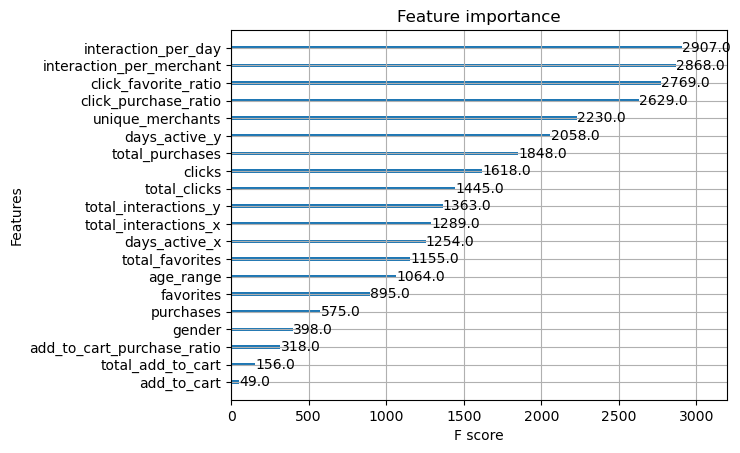

In [17]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=20)
plt.show()

# Step 5: 调整超参数

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_svmlight_file

# 拆分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义初始超参数
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 设置验证集
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
evallist = [(dtrain, 'train'), (dval, 'eval')]

# 训练模型
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=50)

# 评估模型性能
y_pred = bst.predict(dval)
auc_score = roc_auc_score(y_val, y_pred)
print(f'验证集AUC得分: {auc_score}')

[0]	train-auc:0.61827	eval-auc:0.61539
[1]	train-auc:0.62731	eval-auc:0.62053
[2]	train-auc:0.62781	eval-auc:0.62162
[3]	train-auc:0.62971	eval-auc:0.62259
[4]	train-auc:0.63196	eval-auc:0.62432
[5]	train-auc:0.63403	eval-auc:0.62593
[6]	train-auc:0.63482	eval-auc:0.62626
[7]	train-auc:0.63634	eval-auc:0.62695
[8]	train-auc:0.63777	eval-auc:0.62776
[9]	train-auc:0.63910	eval-auc:0.62720
[10]	train-auc:0.63950	eval-auc:0.62746
[11]	train-auc:0.64045	eval-auc:0.62781
[12]	train-auc:0.64161	eval-auc:0.62811
[13]	train-auc:0.64236	eval-auc:0.62901
[14]	train-auc:0.64283	eval-auc:0.62927
[15]	train-auc:0.64308	eval-auc:0.62875
[16]	train-auc:0.64483	eval-auc:0.62932
[17]	train-auc:0.64567	eval-auc:0.62936
[18]	train-auc:0.64689	eval-auc:0.62919
[19]	train-auc:0.64809	eval-auc:0.62975
[20]	train-auc:0.64913	eval-auc:0.62986
[21]	train-auc:0.64973	eval-auc:0.62998
[22]	train-auc:0.65082	eval-auc:0.63078
[23]	train-auc:0.65239	eval-auc:0.63088
[24]	train-auc:0.65340	eval-auc:0.63116
[25]	train

In [19]:
# 调整超参数
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3]
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(**params), param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳超参数
print(f'最佳超参数: {grid_search.best_params_}')

# 使用最佳超参数重新训练模型
best_params = grid_search.best_params_
params.update(best_params)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
evallist = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=50)

# 评估新的模型性能
y_pred = bst.predict(dval)
auc_score = roc_auc_score(y_val, y_pred)
print(f'调整后验证集AUC得分: {auc_score}')

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
最佳超参数: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8}
[0]	train-auc:0.60504	eval-auc:0.60933
[1]	train-auc:0.60839	eval-auc:0.61060
[2]	train-auc:0.60861	eval-auc:0.61032
[3]	train-auc:0.61294	eval-auc:0.61347
[4]	train-auc:0.61187	eval-auc:0.61085
[5]	train-auc:0.61604	eval-auc:0.61624
[6]	train-auc:0.61690	eval-auc:0.61775
[7]	train-auc:0.61778	eval-auc:0.61856
[8]	train-auc:0.61831	eval-auc:0.61888
[9]	train-auc:0.61956	eval-auc:0.61948
[10]	train-auc:0.61929	eval-auc:0.61949
[11]	train-auc:0.61951	eval-auc:0.61985
[12]	train-auc:0.62050	eval-auc:0.62047
[13]	train-auc:0.62125	eval-auc:0.62129
[14]	train-auc:0.62104	eval-auc:0.62149
[15]	train-auc:0.62195	eval-auc:0.62221
[16]	train-auc:0.62208	eval-auc:0.62274
[17]	train-auc:0.62217	eval-auc:0.62250
[18]	train-auc:0.62280	eval-auc:0.62304
[19]	train-auc:0.62307	eval-auc:0.62321
[20]	train-auc:0.62318	eval-auc:0.62315
[2

# Step 6: 测试集预测与保存结果
生成测试集预测并保存为指定的提交格式。

In [20]:
import xgboost as xgb

# 预测测试集
# 确保在创建DMatrix对象时，测试数据集中不包含多余的列
dtest = xgb.DMatrix(test_data.drop(columns=['user_id', 'merchant_id', 'prob'], errors='ignore'))
test_data['prob'] = model.predict(dtest)

# 保存结果
result = test_data[['user_id', 'merchant_id', 'prob']]
result.to_csv('prediction.csv', index=False)
print("预测结果已保存至 prediction.csv")

预测结果已保存至 prediction.csv
